In [123]:
import functools as ft
import os
from dataclasses import fields

import equinox as eqx
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from einops import repeat
from jax import random
from jax import tree_util as jtu
from scipy import constants
from tqdm import tqdm

from ising.primitives2 import get_hamiltonian
from ising.state import Environment, State
from ising.types import Algorithm, BCMode
from ising.utils.random import EasyKey

# CPU cores as separate devices
os.environ['XLA_FLAGS'] = f'--xla_force_host_platform_device_count={os.cpu_count()}'

# config.update("jax_enable_x64", True)
# config.update("jax_check_tracer_leaks", True)

matplotlib.rcParams["figure.figsize"] = (10, 10)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [125]:
# Init
k = EasyKey(np.random.randint(0, 10**10))
rng_key = random.PRNGKey(np.random.randint(0, 10**10))

spin = 0.5
dimensions = 2
size = 32

ENVIRONMENT_BASE_PARAMS = {
    # Beta
    "interaction_bilinear": 1.0,
    "interaction_biquadratic": 0.0,
    "interaction_anisotropy": 0.0,
    "interaction_bicubic": 0.0,
    "interaction_external_field": 1.0,
    "nuclear_magnetic_moment": 1.0,
    "algorithm": Algorithm.METROPOLIS_HASTINGS,
    "bc_mode": BCMode.PERIODIC,
    "bc_mode_value": None,
}

# temperatures = np.geomspace(0.25, 5, 2**6) / constants.Boltzmann * interaction_bilinear
betas = np.geomspace(0.25, 5, 2**5)

n_device_samples = os.cpu_count()
n_subsamples = 4
stepsize = 500
n_steps = 100

In [126]:
# Single state
env = Environment.from_spin(spin=spin, beta=0.5, **ENVIRONMENT_BASE_PARAMS)
state = State.uniform_random_square_from_env(
    rng_key=k.new, dimensions=dimensions, size=size, env=env, id_=0
)

state = state.evolve(10000, rng_key=k.new)

get_hamiltonian(state)
state.calculate_energy()
state.calculate_magnetisation_density()

Array(0.26367188, dtype=float32)

In [127]:
def transforms(in_axes, out_axes):
    def inner(fun):
        fun = eqx.filter_vmap(in_axes=in_axes, out_axes=out_axes)(fun)
        fun = eqx.filter_vmap(in_axes=in_axes, out_axes=out_axes)(fun)
        fun = eqx.filter_jit(fun)
        fun = eqx.filter_pmap(in_axes=in_axes, out_axes=out_axes)(fun)

        return fun

    return inner


@transforms(in_axes=(0, None, None, None, 0, 0, None), out_axes=0)
def make_states(rng_key, spin, dimensions, size, beta, id_, kwargs):
    env = Environment.from_spin(
        spin=spin,
        beta=beta,
        **kwargs,
    )

    rng_key, k = random.split(rng_key, num=2)

    state = State.uniform_random_square_from_env(
        rng_key=k, dimensions=dimensions, size=size, env=env, id_=id_
    )

    return state


@transforms(in_axes=(None, 0, 0), out_axes=0)
def evolve_states(steps, key, state):
    return state.evolve(steps, key)


@transforms(in_axes=(0, 0), out_axes=0)
def measure_states(key, state):
    return state.measure(rng_key=key, num=1, steps=0)


shape = (n_device_samples, n_subsamples, *betas.shape)
state_keys = k.shaped(shape)
ids = np.arange(np.prod(shape)).reshape(shape)

_betas = repeat(
    betas,
    "betas -> device_samples subsamples betas",
    device_samples=n_device_samples,
    subsamples=n_subsamples,
)


states = make_states(
    state_keys, spin, dimensions, size, _betas, ids, ENVIRONMENT_BASE_PARAMS
)

evolve_measurements = []
for i in tqdm(range(n_steps)):
    evolve_keys = k.shaped(shape)
    states = evolve_states(stepsize, evolve_keys, states)

    keys = k.shaped(shape)
    evolve_measurements.append(measure_states(keys, states))

100%|██████████| 100/100 [00:53<00:00,  1.86it/s]


In [128]:
fields(states)[0].metadata

mappingproxy({})

In [135]:
state.measure(rng_key=k.new).vectorisation_shape

()

In [136]:
evolve_measurements[0].unensamble()

[Measurements(
   steps=i32[1],
   state_id=i32[],
   energy=f32[1],
   magnetisation_density=f32[1]
 ),
 Measurements(
   steps=i32[1],
   state_id=i32[],
   energy=f32[1],
   magnetisation_density=f32[1]
 ),
 Measurements(
   steps=i32[1],
   state_id=i32[],
   energy=f32[1],
   magnetisation_density=f32[1]
 ),
 Measurements(
   steps=i32[1],
   state_id=i32[],
   energy=f32[1],
   magnetisation_density=f32[1]
 ),
 Measurements(
   steps=i32[1],
   state_id=i32[],
   energy=f32[1],
   magnetisation_density=f32[1]
 ),
 Measurements(
   steps=i32[1],
   state_id=i32[],
   energy=f32[1],
   magnetisation_density=f32[1]
 ),
 Measurements(
   steps=i32[1],
   state_id=i32[],
   energy=f32[1],
   magnetisation_density=f32[1]
 ),
 Measurements(
   steps=i32[1],
   state_id=i32[],
   energy=f32[1],
   magnetisation_density=f32[1]
 ),
 Measurements(
   steps=i32[1],
   state_id=i32[],
   energy=f32[1],
   magnetisation_density=f32[1]
 ),
 Measurements(
   steps=i32[1],
   state_id=i32[],
   e

In [ ]:
states_list = states.unensamble()

In [ ]:
states_list[0]

[autoreload of ising.state failed: Traceback (most recent call last):
  File "/home/jeppe/Code/IsingModel/.venv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "/home/jeppe/Code/IsingModel/.venv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 471, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/home/jeppe/.pyenv/versions/3.11.2/lib/python3.11/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 940, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/jeppe/Code/IsingModel/ising/state.py", line 95, in <module>
    class Measurements(EnsamblableModule):
  File "/home/jeppe/Code/IsingModel/ising/state.py", line 108, in Measurements
    def vectorisation_shape(

State(
  spins=f32[32,32],
  dim=2,
  env=Environment(
    spin_states=(-0.5, 0.5),
    beta=f32[],
    interaction_bilinear=1.0,
    interaction_biquadratic=0.0,
    interaction_anisotropy=0.0,
    interaction_bicubic=0.0,
    interaction_external_field=1.0,
    nuclear_magnetic_moment=1.0,
    algorithm=<Algorithm.METROPOLIS_HASTINGS: 'metropolis_hastings'>,
    bc_mode=<BCMode.PERIODIC: 'periodic'>,
    bc_mode_value=None
  ),
  id_=i32[],
  steps=i32[]
)

In [ ]:
measurement_keys = [
    "steps",
    "state_id",
    "energy",
    "magnetisation_density",
]
measurements = {
    key: [] for key in measurement_keys
}
for step_m in evolve_measurements:
    for key in measurement_keys:
        data = getattr(step_m, key).flatten().tolist()
        measurements[key].extend(data)
    

@ft.cache
def id_to_beta(id_):
    idx = np.argwhere(states.id_ == id_).flatten()
    idx = tuple(idx)
    return float(states.env.beta[idx])

    
df = pd.DataFrame(measurements)
df["beta"] = df["state_id"].apply(id_to_beta)
df["temperature"] = 1.0 / df["beta"]
df

,steps,state_id,energy,magnetisation_density,beta,temperature
0,500,0,-47.0,0.007812,0.250000,4.000000
1,500,1,-63.0,0.012695,0.275365,3.631544
2,500,2,-88.0,0.016602,0.303304,3.297027
3,500,3,-72.0,0.018555,0.334077,2.993325
4,500,4,-136.0,0.036133,0.367972,2.717598
...,...,...,...,...,...,...
102395,50000,1019,-1504.0,0.500000,3.396997,0.294378
102396,50000,1020,-1504.0,0.500000,3.741656,0.267261
102397,50000,1021,-1504.0,0.500000,4.121284,0.242643
102398,50000,1022,-1504.0,0.500000,4.539430,0.220292


In [ ]:
df.dtypes

steps                      int64
state_id                   int64
energy                   float64
magnetisation_density    float64
beta                     float64
temperature              float64
dtype: object

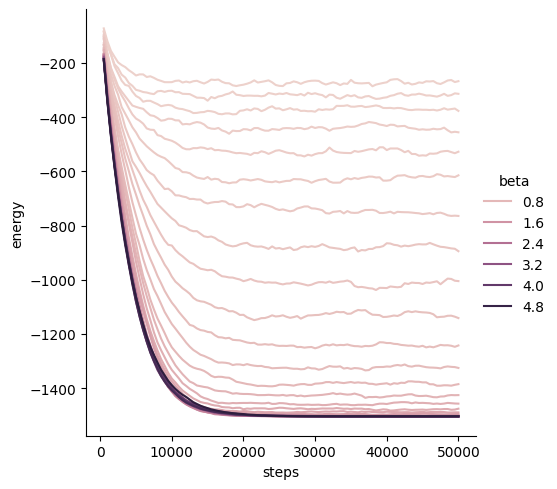

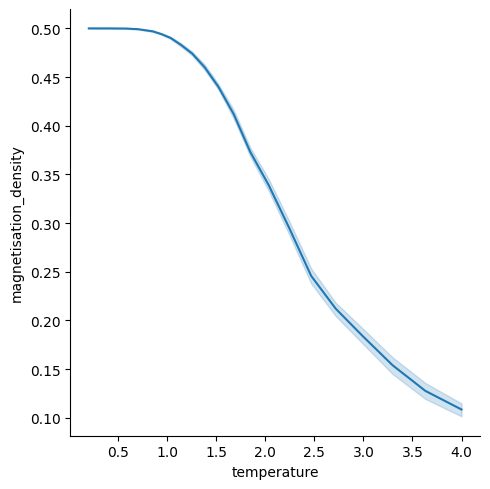

In [ ]:
sns.relplot(
    data=df,
    x="steps",
    y="energy",
    hue="beta",
    kind="line",
    errorbar=None
)
sns.relplot(
    data=df[df["steps"] == np.max(df["steps"])],
    x="temperature",
    y="magnetisation_density",
    # hue="beta",
    kind="line",
    # errorbar=None
)

In [ ]:
states_list = []
for idx in np.ndindex(states.vectorisation_shape):
    states_list.append(jtu.tree_map(lambda x: x[idx] if eqx.is_array(x) else x, states))
    # TODO: WRite https://github.com/patrick-kidger/equinox/issues/313

In [ ]:
np.sin(np.inf)

/tmp/ipykernel_25145/1569643699.py:1: RuntimeWarning: invalid value encountered in sin
  np.sin(np.inf)


nan

In [ ]:
states_list[0]

State(
  spins=f32[32,32],
  dim=2,
  env=Environment(
    spin_states=(-0.5, 0.5),
    beta=f32[],
    interaction_bilinear=1.0,
    interaction_biquadratic=0.0,
    interaction_anisotropy=0.0,
    interaction_bicubic=0.0,
    interaction_external_field=1.0,
    nuclear_magnetic_moment=1.0,
    algorithm=<Algorithm.METROPOLIS_HASTINGS: 'metropolis_hastings'>,
    bc_mode=<BCMode.PERIODIC: 'periodic'>,
    bc_mode_value=None
  ),
  id_=i32[],
  steps=i32[]
)

In [ ]:
states.vectorisation_shape

(8, 4, 32)

In [ ]:
interaction_bilinear = 1.0
interaction_external_field = interaction_bilinear
nuclear_magnetic_moment = 1.0

temperatures = np.geomspace(0.25, 5, 2**6) / constants.Boltzmann * interaction_bilinear

model = IsingModelND(
    2,
    size=64,
    spin=1 / 2,
    interaction_bilinear=interaction_bilinear,
    interaction_external_field=interaction_external_field,
    nuclear_magnetic_moment=nuclear_magnetic_moment,
)
model.initial_state.plot()

steps_per_state = int(3e3)
num_states = 25
states = [model.initial_state.copy() for n in range(len(temperatures))]
all_states = [list(state.copy() for state in states)]
print(f"Doing {steps_per_state * num_states * len(temperatures)} MCMC steps")

for n in tqdm(range(num_states)):
    model.run_steps(states, steps_per_state, temperatures, bc_mode="periodic")
    all_states.append([state.copy() for state in states])

end_magnetisations = [model.get_magnetisation(state) for state in all_states[-1]]

for i, mag in enumerate(end_magnetisations):
    print(f"{i}: {mag:.2f}")

NameError: name 'IsingModelND' is not defined

In [ ]:
# temperature_n = 8
# @interact(value=0, min=0, max=len(all_states))
# def update(i=(0, len(all_states) - 1)):

#     all_states[i][temperature_n].plot()

In [ ]:
# End states


@interact(value=0, min=0, max=len(temperatures))
def update(i=(0, len(temperatures) - 1)):

    all_states[-1][i].plot()

interactive(children=(IntSlider(value=31, description='i', max=63), Output()), _dom_classes=('widget-interact'…

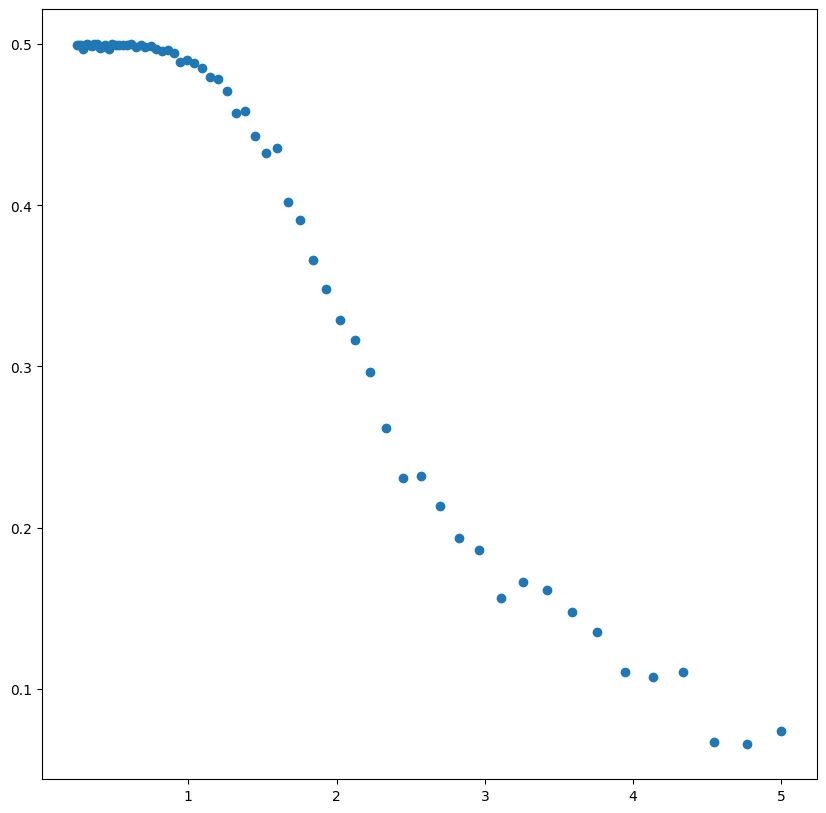

In [ ]:
plt.figure()
x = np.array(temperatures * constants.Boltzmann / interaction_bilinear)
y = [model.get_magnetisation(state) for state in all_states[-1]]

plt.scatter(x, y)

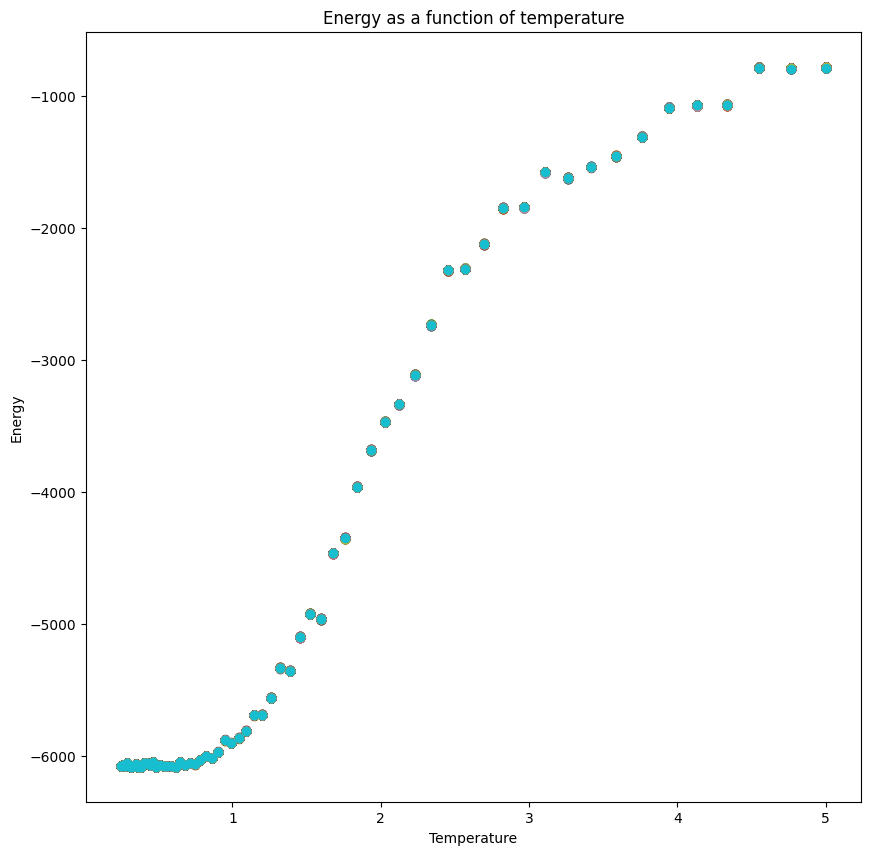

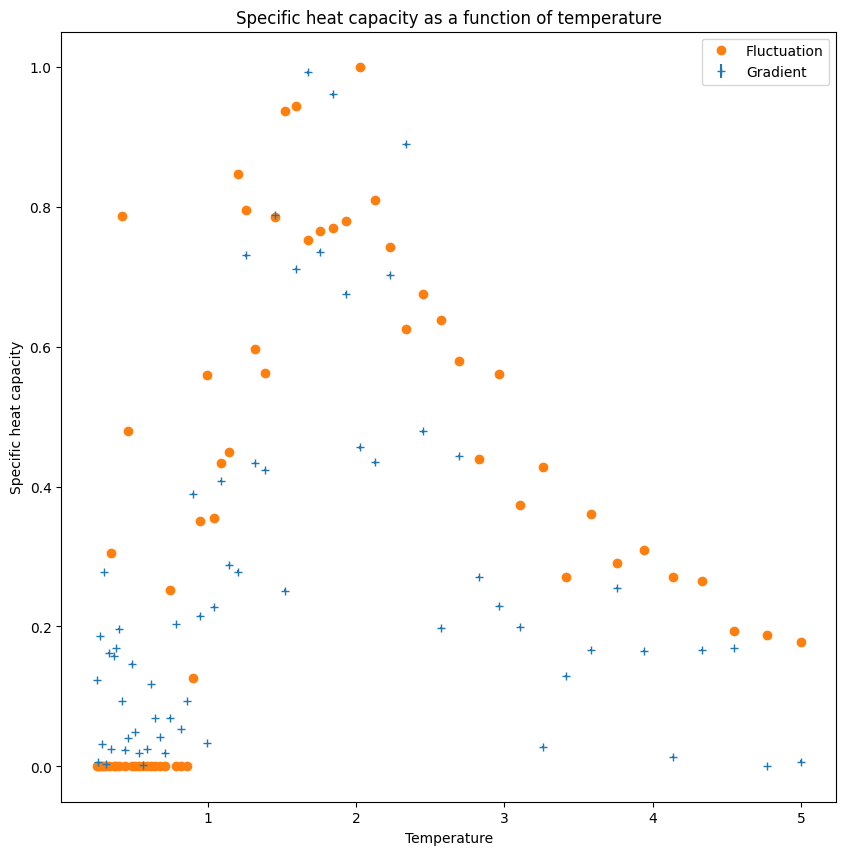

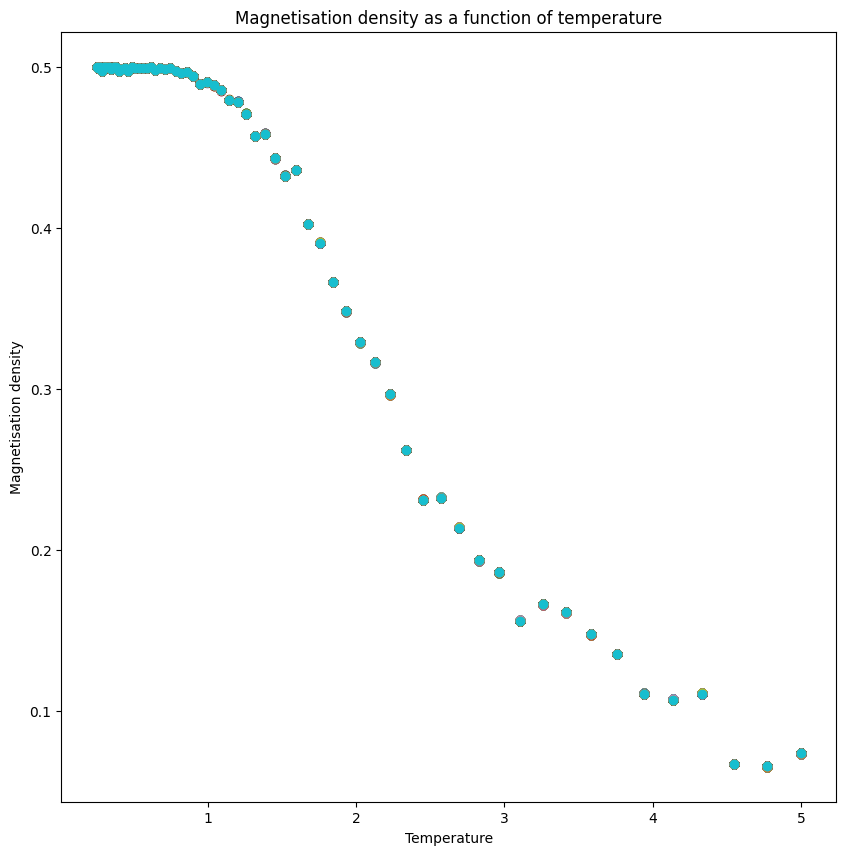

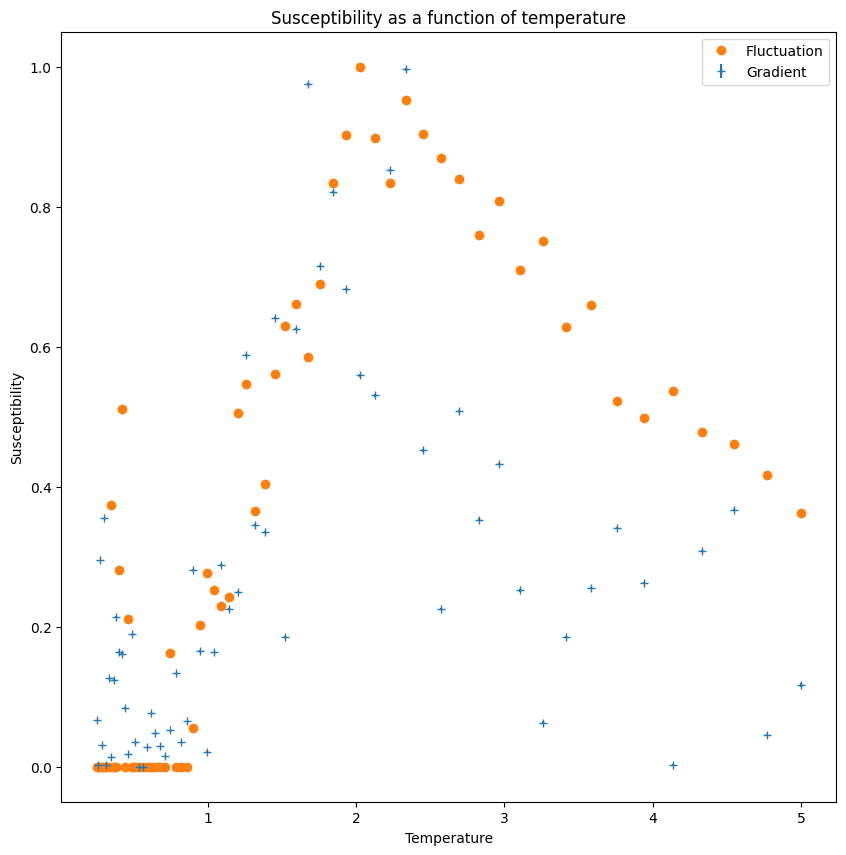

In [ ]:
t = np.array(temperatures * constants.Boltzmann / interaction_bilinear)

equilibrium_steps = 500
equilibrium_properties = model.get_equilibrium_energies_and_magnetisations(states, equilibrium_steps, temperatures)

energies = equilibrium_properties[:, :, 0]
magnetisation_densities = equilibrium_properties[:, :, 1]

heat_cap_gradient = np.abs(np.gradient(energies, t, axis=0))
heat_cap_gradient = heat_cap_gradient / heat_cap_gradient.max()
heat_cap_gradient_std = heat_cap_gradient.std(axis=1)

energies_std = energies.std(axis=1)
heat_cap_fluctuation = np.square(energies_std) / (constants.Boltzmann * np.square(t))
heat_cap_fluctuation = heat_cap_fluctuation / heat_cap_fluctuation.max()

susceptibilities_gradient = np.abs(np.gradient(magnetisation_densities, t, axis=0))
susceptibilities_gradient = susceptibilities_gradient / susceptibilities_gradient.max()
susceptibilities_gradient_std = susceptibilities_gradient.std(axis=1)

magnetisation_densities_std = magnetisation_densities.std(axis=1)
susceptibilities_fluctuation = np.square(magnetisation_densities_std) / (constants.Boltzmann * np.square(t))
susceptibilities_fluctuation = susceptibilities_fluctuation / susceptibilities_fluctuation.max()

plt.figure()
plt.title("Energy as a function of temperature")
plt.xlabel("Temperature")
plt.ylabel("Energy")
plt.plot(t, energies, "o")

plt.figure()
plt.title("Specific heat capacity as a function of temperature")
plt.xlabel("Temperature")
plt.ylabel("Specific heat capacity")
plt.errorbar(t, heat_cap_gradient[:, 0], heat_cap_gradient_std, fmt="+", label="Gradient")
plt.plot(t, heat_cap_fluctuation, "o", label="Fluctuation")
plt.legend()

plt.figure()
plt.title("Magnetisation density as a function of temperature")
plt.xlabel("Temperature")
plt.ylabel("Magnetisation density")
plt.plot(t, magnetisation_densities, "o")

plt.figure()
plt.title("Susceptibility as a function of temperature")
plt.xlabel("Temperature")
plt.ylabel("Susceptibility")
plt.errorbar(t, susceptibilities_gradient[:, 0], susceptibilities_gradient_std, fmt="+", label="Gradient")
plt.plot(t, susceptibilities_fluctuation, "o", label="Fluctuation")
plt.legend()

In [ ]:
from scipy.ndimage import generate_binary_structure

sites = generate_binary_structure(3, 1)
np.put(sites, sites.size // 2, False)

sites

array([[[False, False, False],
        [False,  True, False],
        [False, False, False]],

       [[False,  True, False],
        [ True, False,  True],
        [False,  True, False]],

       [[False, False, False],
        [False,  True, False],
        [False, False, False]]])